# Step 1 - Frame Dividing Part

#### Install Opencv for Frame Extraction

In [1]:
pip install opencv-python-headless

  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-win_amd64.whl (39.4 MB)
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
    --------------------------------------- 0.3/12.9 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.9 MB 728.2 kB/s eta 0:00:18
   -- ------------------------------------- 0.8/12.9 MB 905.5 kB/s eta 0:00:14
   -- ------------------------------------- 0.8/12.9 MB 905.5 kB/s eta 0:00:14
   --- ------------------------------------ 1.0/12.9 MB 986.7 kB/s eta 0:00:13
   ---- ----------------------------------- 1.3/12.9 MB 1.0 MB/s eta 0:00:12
   ---- ----------------------------------- 1.6/12.9 MB 998.3 kB/s eta 0:00:12
   ----- ---------------------------------- 1.8/12.9 MB 986.7 kB/s eta 0:00:12
   ----- ---------------------------------- 1.8/12.9 MB 986.7 kB/s eta

#### Importing Libraries CV2 and OS

In [2]:
import cv2
import os

#### Function to Extract Frames

In [2]:
import os
import cv2

def extract_frames(video_path, output_folder, frame_rate=5, resize=(224, 224)):
    """Extract resized frames from a video and save to output_folder"""
    os.makedirs(output_folder, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    interval = max(1, int(fps / frame_rate))

    count = 0
    frame_id = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % interval == 0:
            resized = cv2.resize(frame, resize)
            frame_path = os.path.join(output_folder, f"frame_{frame_id:04d}.jpg")
            cv2.imwrite(frame_path, resized)
            frame_id += 1
        count += 1
    cap.release()
    print(f"Extracted {frame_id} frames from {video_path} → {output_folder}")

def process_all_videos(input_root, output_root, frame_rate=5):
    """Walk through input_root, find all .mp4/.mov, and extract frames into a folder named after each video"""
    for root, _, files in os.walk(input_root):
        for file in files:
            if file.endswith(('.mp4', '.MOV')):
                video_path = os.path.join(root, file)
                
                # Get relative path from input_root to current set folder
                rel_folder = os.path.relpath(root, input_root)
                
                # Output folder is: output_root / relative_folder / video_name_without_ext
                video_name = os.path.splitext(file)[0]
                output_folder = os.path.join(output_root, rel_folder, video_name)

                extract_frames(video_path, output_folder, frame_rate)




In [ ]:


# Example usage
input_root = "Input"
output_root = "Output"
process_all_videos(input_root, output_root, frame_rate=5)

## Step 2 -After Annotation Creating Dataset

In [ ]:
import os
import json
import csv

def collect_phase_labels(root_folder, output_csv, image_extension=".jpg"):
    """
    Traverse the nested folder structure and generate a CSV file containing
    frame image paths and their corresponding weightlifting phase labels.

    Arguments:
    - root_folder: Root directory where player data is stored.
    - output_csv: Path to save the generated CSV file.
    - image_extension: Extension of frame images (default: .jpg)
    """
    
    rows = []  # List to hold [frame_path, label] rows

    # Iterate through each player directory (e.g., Player_01, Player_02)
    for player in os.listdir(root_folder):
        player_path = os.path.join(root_folder, player)
        if not os.path.isdir(player_path):
            continue  # Skip if not a folder

        # Iterate through movement types (e.g., FS, CJ)
        for movement in os.listdir(player_path):
            movement_path = os.path.join(player_path, movement)
            if not os.path.isdir(movement_path):
                continue

            # Iterate through sets (e.g., Player01_FS_Set_01)
            for set_folder in os.listdir(movement_path):
                set_path = os.path.join(movement_path, set_folder)
                if not os.path.isdir(set_path):
                    continue

                # Iterate through view folders (e.g., front_view, side_view)
                for view_folder in os.listdir(set_path):
                    view_path = os.path.join(set_path, view_folder)
                    if not os.path.isdir(view_path):
                        continue

                    # Look for the data.json annotation file in the view folder
                    json_path = os.path.join(view_path, "data.json")
                    if not os.path.exists(json_path):
                        continue

                    # Try to load the JSON annotation
                    try:
                        with open(json_path, 'r') as f:
                            data = json.load(f)
                    except:
                        print(f"❌ Failed to load JSON: {json_path}")
                        continue

                    # Iterate through each annotated phase
                    for phase in data.get("phases", []):
                        start = phase["start_frame"]
                        end = phase["end_frame"]
                        label = phase["phase"]

                        # For each frame in the phase range, create a row
                        for i in range(start, end + 1):
                            frame_name = f"frame_{i:04d}{image_extension}"  # e.g., frame_0390.jpg
                            frame_path = os.path.join(view_path, frame_name)
                            if os.path.exists(frame_path):
                                rows.append([os.path.abspath(frame_path), label])  # Save absolute path

    # Save all collected rows into a CSV file
    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["frame_path", "label"])  # Header
        writer.writerows(rows)

    print(f"✅ CSV saved to {output_csv} with {len(rows)} labeled frames.")


# Example usage
root_folder = "Input"
output_csv = "Dataset.csv"
collect_phase_labels(root_folder, output_csv)


✅ CSV saved to Dataset.csv with 1628 labeled frames.


## Step 3 - After Creating dataset Train the model

#### Install Tenserflow

In [3]:
pip install tensorflow


  Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl.metadata (4.1 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached h5py-3.14.0-cp310-cp310-win_amd64.whl.metadata (2.7 kB)
  Using cached ml_dtypes-0.5.1-cp310-cp310-win_amd64.whl.metadata (22 kB)
  Using cached rich-14.0.0-py3-none-any.whl.metadata (18 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl (375.7 MB)
Using cached ml_dtypes-0.5.1-cp310-cp310-win_amd64.whl (209 kB)
Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
Using cached h5py-3.14.0-cp310-cp310-win_amd64.whl (2.9 MB)
Using cached keras-3.10.0-py3-none-any.whl (1.4 MB)
Using cached rich-14.0.0-py3-none-any.whl (243 kB)
Using cached markdown_it_py-3.0

#### Install Scikit learn

In [4]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


#### Install Numpy

In [5]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


#### Install Pandas

In [6]:
pip install pandas

#### Install OpenCV

In [7]:
pip install opencv-python-headless

#### Prepare Dataset fot Training

In [9]:
# Import necessary libraries
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def load_dataset(csv_path, img_size=(224, 224)):
    """
    Loads image dataset and corresponding labels from a CSV file and prepares it
    for training a CNN model.

    Args:
        csv_path (str): Path to the CSV file containing image paths and labels.
        img_size (tuple): Target size to resize each image (width, height).

    Returns:
        X (np.array): Array of image data.
        y (np.array): One-hot encoded labels.
        class_names (list): List of class names in order of encoding.
    """
    
    # Read CSV file into a pandas DataFrame
    df = pd.read_csv(csv_path)

    # Get sorted list of unique labels (phases)
    class_names = sorted(df['label'].unique())

    # Create a mapping from label name to integer index
    class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}

    # Initialize lists to hold image data and labels
    images = []
    labels = []

    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        # Load the image from the file path
        img = cv2.imread(row['frame_path'])

        # Resize the image to the specified size
        img = cv2.resize(img, img_size)

        # Normalize pixel values to range [0, 1]
        img = img / 255.0

        # Append processed image and its corresponding label
        images.append(img)
        labels.append(class_to_idx[row['label']])

    # Convert image list to NumPy array
    X = np.array(images, dtype=np.float32)

    # Convert labels to one-hot encoded format
    y = to_categorical(labels, num_classes=len(class_names))

    # Return image data, labels, and class name list
    return X, y, class_names


#### Load The Dataset

In [10]:
X, y, class_names = load_dataset('Dataset.csv', img_size=(224, 224))


#### Train Split 

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


#### Create The Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define a sequential CNN model
model = Sequential([
    # First convolutional layer with 32 filters of size 3x3, ReLU activation
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    
    # Max pooling layer to reduce spatial dimensions (downsampling)
    MaxPooling2D(2, 2),

    # Second convolutional layer with 64 filters
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Third convolutional layer with 128 filters
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten the feature maps into a 1D vector for the fully connected layer
    Flatten(),

    # Fully connected (dense) layer with 128 neurons
    Dense(128, activation='relu'),

    # Dropout layer to prevent overfitting by randomly turning off 50% of neurons
    Dropout(0.5),

    # Output layer with one neuron per class and softmax activation
    Dense(len(class_names), activation='softmax')
])

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(
    optimizer='adam',                  # Optimizer algorithm
    loss='categorical_crossentropy',   # Loss function for multi-class classification
    metrics=['accuracy']               # Track accuracy metric during training
)


d:\AI Research\AI CNN Model\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Train the Model

In [35]:
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 384ms/step - accuracy: 0.4068 - loss: 2.3554 - val_accuracy: 0.5276 - val_loss: 1.5792
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 361ms/step - accuracy: 0.5253 - loss: 1.6519 - val_accuracy: 0.5276 - val_loss: 1.3569
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 362ms/step - accuracy: 0.5243 - loss: 1.3178 - val_accuracy: 0.5583 - val_loss: 0.9458
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 359ms/step - accuracy: 0.5591 - loss: 1.0300 - val_accuracy: 0.6350 - val_loss: 0.7601
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 358ms/step - accuracy: 0.6435 - loss: 0.8338 - val_accuracy: 0.7086 - val_loss: 0.6035
Epoch 6/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 358ms/step - accuracy: 0.7079 - loss: 0.6575 - val_accuracy: 0.7454 - val_loss: 0.5106
Epoch 7/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 362ms/step - accuracy: 0.7077 - loss: 0.6646 - val_accuracy: 0.7853 - val_loss: 0.5215
Epoch 8/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 358ms/step - accuracy: 0.7298 - loss: 0.5953 - val_accu

#### Validation Metrics

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Evaluate model on validation set
loss, accuracy = model.evaluate(X_val, y_val)
print(f'✅ Validation Accuracy from model.evaluate(): {accuracy:.2f}')
print(f'📉 Validation Loss: {loss:.4f}')

# Prepare ground truth and predictions
y_true = np.argmax(y_val, axis=1)  # Convert one-hot to class indices
y_pred_probs = model.predict(X_val)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to predicted class indices

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f'\n🎯 Sklearn Accuracy Score: {acc:.2f}')

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Save the model
model.save('phase_classifier_cnn.h5')


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.7998 - loss: 0.3920
✅ Validation Accuracy from model.evaluate(): 0.82
📉 Validation Loss: 0.3605
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step



🎯 Sklearn Accuracy Score: 0.82

📊 Classification Report:
              precision    recall  f1-score   support

         End       1.00      0.61      0.76        23
  Transition       0.80      0.80      0.80        10
    Turnover       0.85      0.82      0.84        28
       catch       0.84      0.46      0.59        35
  first_pull       0.76      0.76      0.76        21
     nothing       0.83      0.93      0.88       172
 second_pull       0.90      0.64      0.75        14
       start       0.67      0.96      0.79        23

    accuracy                           0.82       326
   macro avg       0.83      0.75      0.77       326
weighted avg       0.83      0.82      0.81       326



#### Confusion Matrix

In [13]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('📊 Confusion Matrix')
    plt.tight_layout()
    plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


C:\Users\DS\AppData\Local\Temp\ipykernel_27572\2287998383.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\AI Research\AI CNN Model\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


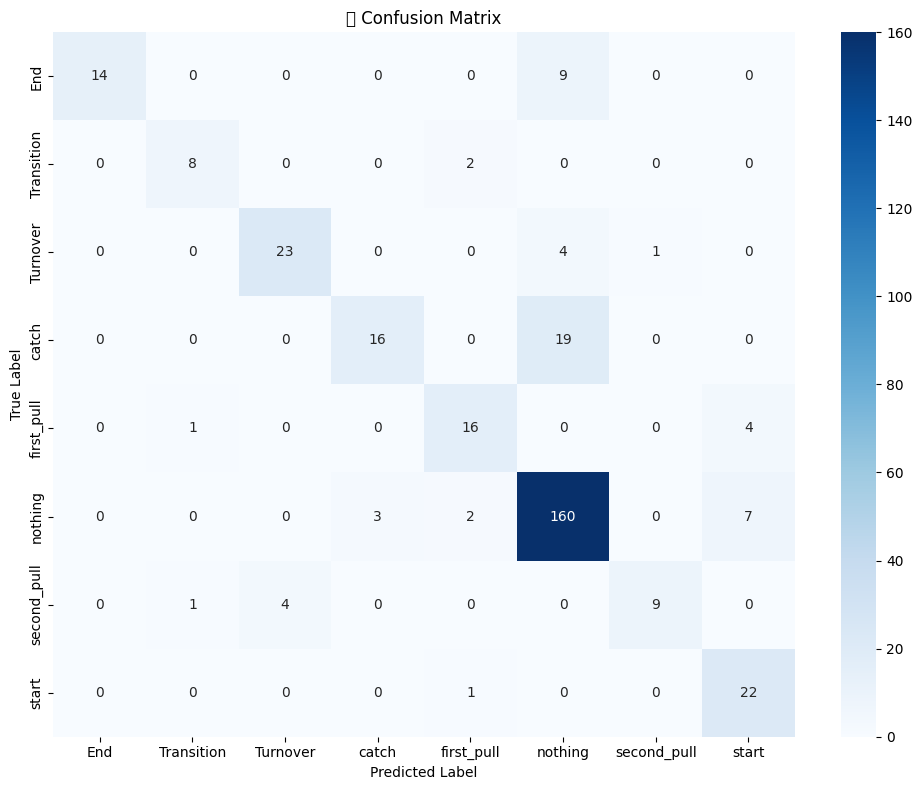

In [15]:
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(model.predict(X_val), axis=1)

plot_confusion_matrix(y_true, y_pred, class_names)


#### Install matplotlib

In [37]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


#### Plotting Training History

In [18]:
import matplotlib.pyplot as plt


def plot_training_history(history):
    plt.figure(figsize=(12,5))
    
    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()


In [20]:
plot_training_history(history)

NameError: name 'history' is not defined

## Inferencing

In [22]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

def predict_phase(image_path, model, class_names, img_size=(224,224)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # batch dimension
    
    preds = model.predict(img)
    pred_idx = np.argmax(preds)
    pred_label = class_names[pred_idx]
    
    return pred_label


In [24]:
print(class_names)

['End', 'Transition', 'Turnover', 'catch', 'first_pull', 'nothing', 'second_pull', 'start']


In [29]:
model = load_model('phase_classifier_cnn.h5')
# Fix with forward slashes (also works on Windows)
image_path = "Input/Player_01/FS/Player01_FS_Set_02/Player01_FS_50Kg_front_view/frame_0221.jpg"

class_names = ['End', 'Transition', 'Turnover', 'catch', 'first_pull', 'nothing', 'second_pull', 'start']
label = predict_phase(image_path, model, class_names)
print(f"Predicted phase: {label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted phase: second_pull
